<a href="https://colab.research.google.com/github/arminnv/Deep-Learning-Fall-2024/blob/main/HW5/Q1_VAE_CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoders

Full Name:

Student ID:


# Variational Autoencoder

In this notebook, you will implement a variational autoencoder and a conditional variational autoencoder with slightly different architectures and apply them to the popular MNIST handwritten dataset.

Load several useful packages that are used in this notebook:

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import random
import cv2
import matplotlib as mpl
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [ ]:
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

## Load MNIST Dataset


VAEs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable, we will be working on the MNIST dataset, which has 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy.

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset.

In [2]:
batch_size = 128

mnist_train = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.42MB/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



## Visualize dataset

It is always a good idea to look at examples from the dataset before working with it. Let's visualize the digits in the MNIST dataset. We have defined the function `show_images` to visualize the images.


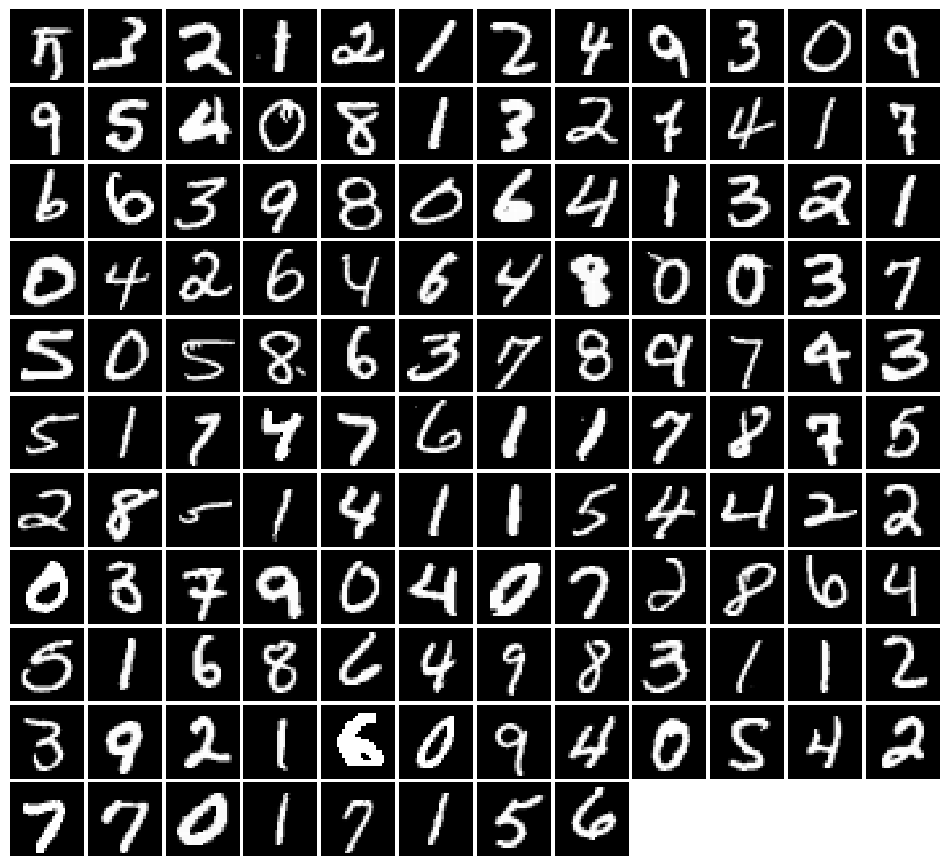

In [3]:
def show_images(images):
    images = torch.reshape(
        images, [images.shape[0], -1]
    )
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([sqrtimg, sqrtimg]))
    return

data_iter = iter(loader_train)
imgs, _ = next(data_iter)
imgs = imgs.view(batch_size, 784)
show_images(imgs)

# Fully Connected VAE

Your first VAE implementation will consist solely of fully connected layers. You'll take the `1 x 28 x 28` shape of our input and flatten the features to create an input dimension size of 784. In this section you'll define the Encoder and Decoder models in the VAE class and implement the reparametrization trick, forward pass, and loss function to train your first VAE.

## FC-VAE Forward

Complete the VAE class by writing the initialization and the forward pass. The forward pass should pass the input image through the encoder to calculate the estimation of mu and logvar, reparametrize to estimate the latent space z, and finally pass z into the decoder to generate an image.



In [12]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        self.latent_size = latent_dim
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim // 2, self.latent_size)
        self.fc_logvar = nn.Linear(hidden_dim // 2, self.latent_size)

        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(self.latent_size, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Output values between 0 and 1
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + std * eps

        return z

    def forward(self, x):
        # TODO: Implement the forward pass
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        z = self.reparameterize(mu, logvar)

        reconstructed = self.decoder(z)
        reconstructed = torch.unflatten(reconstructed, dim=1, sizes=(28, 28))

        return reconstructed, logvar, mu

## Loss Function

Complete the vae_loss function below

In [8]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    recon_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    total_loss = recon_loss + kl_loss

    return total_loss


## Train a model

Now that we have our VAE defined and loss function ready, lets train our model!

Complete the train_vae_mlp function to train the network.

In [14]:
def train_vae_mlp(model, train_loader, num_epochs=20, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for epoch in range(num_epochs):
        print()
        print(45 * "=")
        total_loss = []
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process
            optimizer.zero_grad()
            recon, logvar, mu = model(data)

            # TODO: Flatten the data and recon tensors
            data = torch.flatten(data, 1)
            recon = torch.flatten(recon, 1)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)


            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()
            #loss =
            total_loss.append(loss.item())

        avg_loss = float(sum(total_loss)/len(total_loss))
        print(f'VAE- Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

In [15]:
# TODO: Train VAE
latent_size = 10
VAE = VAE_MLP(input_dim=784 , hidden_dim=128 , latent_dim=latent_size, device=device)
train_vae_mlp(VAE, loader_train)


VAE- Epoch [1/20], Loss: 26081.395411825586

VAE- Epoch [2/20], Loss: 19559.60255158253

VAE- Epoch [3/20], Loss: 17169.570506560496

VAE- Epoch [4/20], Loss: 16297.364345452725

VAE- Epoch [5/20], Loss: 15786.85304821047

VAE- Epoch [6/20], Loss: 15461.623255542201

VAE- Epoch [7/20], Loss: 15233.365576589209

VAE- Epoch [8/20], Loss: 15047.474285940838

VAE- Epoch [9/20], Loss: 14883.457016643297

VAE- Epoch [10/20], Loss: 14746.741469684828

VAE- Epoch [11/20], Loss: 14648.172114967281

VAE- Epoch [12/20], Loss: 14569.665552383814

VAE- Epoch [13/20], Loss: 14492.627251519098

VAE- Epoch [14/20], Loss: 14424.713019998664

VAE- Epoch [15/20], Loss: 14373.192931607238

VAE- Epoch [16/20], Loss: 14315.78088691907

VAE- Epoch [17/20], Loss: 14272.786341479701

VAE- Epoch [18/20], Loss: 14232.730429103232

VAE- Epoch [19/20], Loss: 14193.54349876469

VAE- Epoch [20/20], Loss: 14160.143815521502


## Visualize results

After training our VAE network, we're able to take advantage of its power to generate new training examples. This process simply involves the decoder: we intialize some random distribution for our latent spaces z, and generate new examples by passing these latent space into the decoder.

Run the cell below to generate new images! You should be able to visually recognize many of the digits, although some may be a bit blurry or badly formed. Our next model will see improvement in these results.

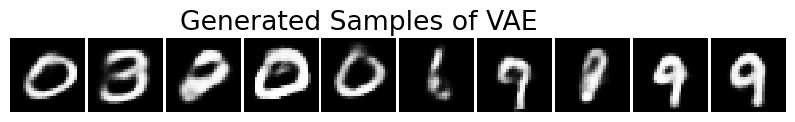

In [17]:
num_samples = 10
z = torch.randn(num_samples, latent_size).to(device=device)

VAE.eval()
samples = VAE.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(num_samples, 1))
gspec = gridspec.GridSpec(1, num_samples)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    if i == 4:
      plt.title('Generated Samples of VAE')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,28), cmap='Greys_r')

# Conditional FC-VAE

The second model you'll develop will be very similar to the FC-VAE, but with a slight conditional twist to it. We'll use what we know about the labels of each MNIST image, and *condition* our latent space and image generation on the specific class. Instead of $q_{\phi} (z|x)$ and $p_{\phi}(x|z)$ we have $q_{\phi} (z|x,c)$  and $p_{\phi}(x|z, c)$

This will allow us to do some powerful conditional generation at inference time. We can specifically choose to generate more 1s, 2s, 9s, etc. instead of simply generating new digits randomly.

## Define Network with class input

Your CVAE architecture should be the same as your FC-VAE architecture, except you'll now concatenate a one-hot label vector to both the x input (in our case, the flattened image dimensions) and the z latent space.

If the one-hot vector is called `c`, then `c[label] = 1` and `c = 0` elsewhere.

For the `CVAE_MLP` class use the same FC-VAE architecture implemented in the last network.


In [43]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes, device):
        super(CVAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder
        self.latent_size = latent_dim
        self.embed_dim = 10
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Flatten(),
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim // 2, self.latent_size)
        self.fc_logvar = nn.Linear(hidden_dim // 2, self.latent_size)
        self.fc_class = nn.Linear(self.latent_size, num_classes)

        # TODO: Define the architecture of the decoder
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(self.latent_size + num_classes, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + std * eps

        return z

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        input = torch.cat((x, y), dim=1)

        # TODO: Implement the forward pass
        encoded = self.encoder(input)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)

        z = self.reparameterize(mu, logvar)

        reconstructed = self.decoder(torch.cat((z, y), dim=1))
        reconstructed = torch.unflatten(reconstructed, dim=1, sizes=(28, 28))

        predicted = self.fc_class(z)

        return reconstructed, logvar, mu, predicted




If you want to build helper functions, you can write the code in the below cell.

# Loss Function

Complete the cvae_loss function below

In [40]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor

    # TODO: Implement the reconstruction loss
    recon_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Implement the cross-entropy loss for class prediction
    prediction_loss = F.cross_entropy(class_logits, labels)


    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    total_loss = recon_loss + kl_loss + prediction_loss



    return total_loss


## Train model

Using the same training script, let's now train our CVAE!



In [50]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=20, learning_rate=1e-3):
    model.train()
    num_classes = 10
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for epoch in range(num_epochs):
        print()
        print(45 * "=")
        total_loss = []
        for batch_idx, (data, labels) in enumerate(train_loader):
            # One-hot encode the labels
            y = torch.nn.functional.one_hot(labels, num_classes).to(torch.float32)
            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon, logvar, mu, predicted = model(data, y)
            data = torch.flatten(data, 1)
            recon = torch.flatten(recon, 1)


            # TODO: Backpropagation and optimization step
            optimizer.zero_grad()
            loss = cvae_loss(recon, data, mu, logvar, predicted, labels)
            loss.backward()
            optimizer.step()
            total_loss.append(loss.item())


        avg_loss = float(sum(total_loss)/len(total_loss))
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

In [51]:
# TODO: Train CVAE
latent_size = 10
CVAE = CVAE_MLP(input_dim=784 , hidden_dim=128 , latent_dim=latent_size , num_classes=10, device=device)
train_cvae_mlp(CVAE, loader_train)


CVAE-MLP Epoch [1/20], Loss: 25128.387641059027

CVAE-MLP Epoch [2/20], Loss: 18403.881771250668

CVAE-MLP Epoch [3/20], Loss: 16774.022116636617

CVAE-MLP Epoch [4/20], Loss: 15898.058140942174

CVAE-MLP Epoch [5/20], Loss: 15382.318870609643

CVAE-MLP Epoch [6/20], Loss: 15024.364938067574

CVAE-MLP Epoch [7/20], Loss: 14744.349774222088

CVAE-MLP Epoch [8/20], Loss: 14546.30065604968

CVAE-MLP Epoch [9/20], Loss: 14391.601643880209

CVAE-MLP Epoch [10/20], Loss: 14269.21065579928

CVAE-MLP Epoch [11/20], Loss: 14159.48284755609

CVAE-MLP Epoch [12/20], Loss: 14064.844236194578

CVAE-MLP Epoch [13/20], Loss: 13984.814574151977

CVAE-MLP Epoch [14/20], Loss: 13909.372594067174

CVAE-MLP Epoch [15/20], Loss: 13843.592164129273

CVAE-MLP Epoch [16/20], Loss: 13786.579064002404

CVAE-MLP Epoch [17/20], Loss: 13735.577847472623

CVAE-MLP Epoch [18/20], Loss: 13685.356672759748

CVAE-MLP Epoch [19/20], Loss: 13642.646778595754

CVAE-MLP Epoch [20/20], Loss: 13596.37720352564


## Visualize Results

You've trained your CVAE, now let's conditionally generate some new data! This time, we can specify the class we want to generate by adding our one hot matrix of class labels. We use `torch.eye` to create an identity matrix, which effectively gives us one label for each digit. When you run the cell below, you should get one example per digit. Each digit should be reasonably distinguishable (it is ok to run this cell a few times to save your best results).



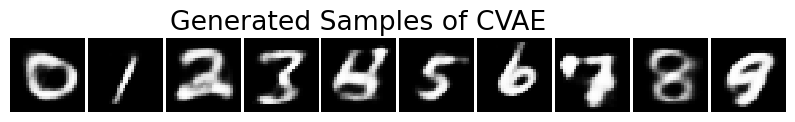

In [57]:
num_samples = 10
z = torch.randn(num_samples, latent_size)

c = torch.eye(num_samples, 10)

z = torch.cat((z,c), dim=-1).to(device='cpu')
CVAE.eval()
samples = CVAE.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(num_samples, 1))
gspec = gridspec.GridSpec(1, num_samples)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    if i == 4:
      plt.title('Generated Samples of CVAE')
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')